In [1]:
if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import torch
from sklearn.decomposition import PCA
from agents.networks.gru_rnn import GRU_RNN

AVERAGING_SIZE = 20

color_set_1 = [
    '#E4F1F7',
    '#C5E1EF',
    '#9EC9E2',
    '#6CB0D6',
    '#3C93C2',
    '#226E9C',
    '#0D4A70',
    '#054166',
]

color_set_2 = [
    '#F9D8E6',
    '#F2ACCA',
    '#ED85B0',
    '#E95694',
    '#E32977',
    '#C40F5B',
    '#8F003B',
    '#69022c',
]

HIDDEN_SIZE = 32
INPUT_SIZE = 1

In [62]:
hypo_data = [
    'test_line_attractor_init_0_2024-12-17_14_39_08_208644_var_noise_5e-05_activity_weight_1e-07',
]

ctrl_data = [
]

In [63]:
def load_numpy(data_path, averaging_size=1, concat_ax=0):
    file_names = glob.glob(data_path)
    data = []
    for file_name in file_names:
        data_for_file = np.load(file_name)
        data.append(data_for_file)
    data = np.concatenate(data, axis=concat_ax)
    if averaging_size == 1:
        return data
    reduced_data = np.empty((data.shape[0], int(data.shape[1] / averaging_size)))
    for k in range(0, int(data.shape[1] / averaging_size) * averaging_size, averaging_size):
        reduced_data[:, int(k / averaging_size)] = data[:, k:k + averaging_size].mean(axis=1)
    return reduced_data

In [64]:
hidden_state_data = None
for i_d, d in enumerate(hypo_data):
    hs_path = f'../../results/line_attr_supervised/{d}/hidden_states/*.npy'
    o_path = f'../../results/line_attr_supervised/{d}/outputs/*.npy'
    hidden_state_data = load_numpy(hs_path)
    output_data = load_numpy(o_path, concat_ax=1)

print(hidden_state_data.shape)

(2000, 32, 500)


(2, 2000)


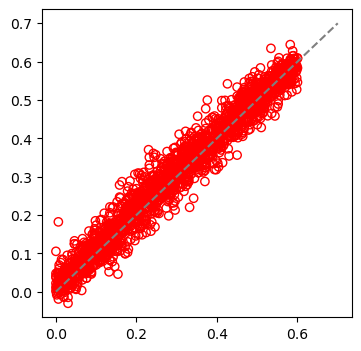

In [65]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

# output_data = output_data.reshape((2, 2000), order='F')
print(output_data.shape)

cbar = axs.scatter(output_data[1, :], output_data[0, :], edgecolor='red', facecolor='none')
axs.plot([0, 0.7], [0, 0.7], '--', c='gray')

[-0.03039719 -0.01926623 -0.01486602 ...  0.62791884  0.634597
  0.6443634 ]
0
200
400
600
800
1000
1200
1400
1600
1800


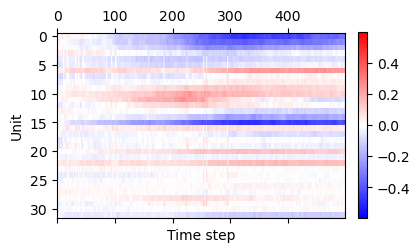

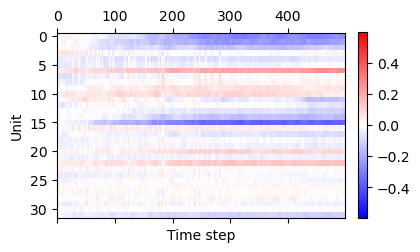

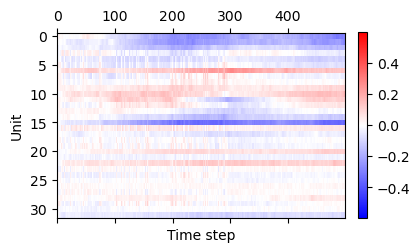

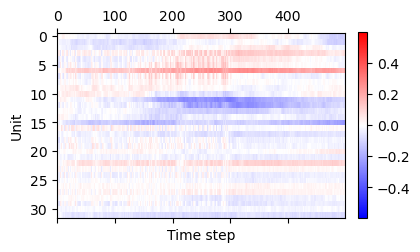

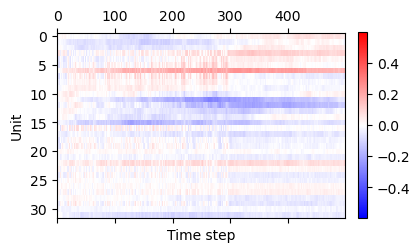

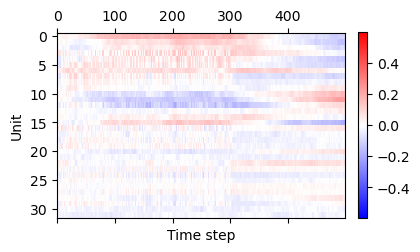

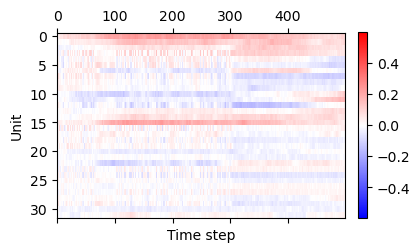

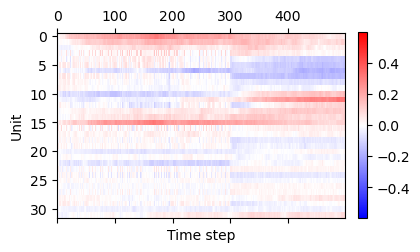

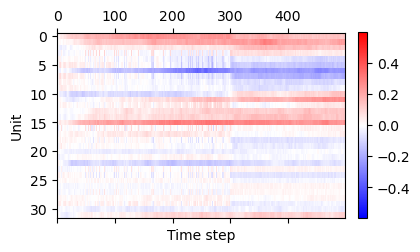

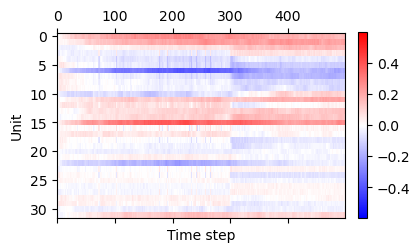

In [99]:
m = np.abs(hidden_state_data).max()

sorted_hidden_activity = hidden_state_data[output_data[0, :].argsort(), ...]

print(output_data[0, :][output_data[0, :].argsort()])

for k in range(0, 2000, 200):
    print(k)
    hidden_activity = sorted_hidden_activity[k, ...]
    
    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
    axs.set_ylabel('Unit')
    axs.set_xlabel('Time step')

    cbar = axs.matshow(hidden_activity, vmin=-m, vmax=m, cmap='bwr', aspect=10)
    plt.colorbar(cbar, fraction=0.03, pad=0.04)

# PC space representation

(32, 2000, 500)
(32, 1000000)
[[ 0.37545362  0.3599813   0.19180556  0.02004723  0.00107111 -0.05435493
  -0.41503015 -0.10054713 -0.06466683 -0.09106471 -0.0756945   0.17933348
   0.05210399  0.15032499  0.2128186   0.5467211  -0.01748499  0.08301745
  -0.02178192 -0.00827993 -0.09346275  0.0349895  -0.19285905  0.00495277
  -0.01679674  0.00680161 -0.01142624 -0.00354183  0.00770368  0.0073654
  -0.03140846  0.1748646 ]
 [-0.3372539  -0.12913987 -0.11398127 -0.12209971 -0.2646501  -0.26556274
  -0.3004795  -0.21146168 -0.07713417  0.04511236  0.31539443  0.52330804
   0.29644912  0.14591211 -0.01593636 -0.13671134  0.07357322  0.02829142
  -0.05123166 -0.06832829  0.1285589   0.00298557  0.01138278  0.0185386
  -0.02743012  0.00089461  0.02440781 -0.01824364  0.11689278  0.0082531
   0.01862874  0.10203916]
 [ 0.00331568 -0.13669485 -0.27309367 -0.314484    0.0185305   0.21600696
  -0.27494383  0.36784407  0.18210459  0.16109428 -0.23630515 -0.02826419
   0.3073626  -0.0512482  -0.17

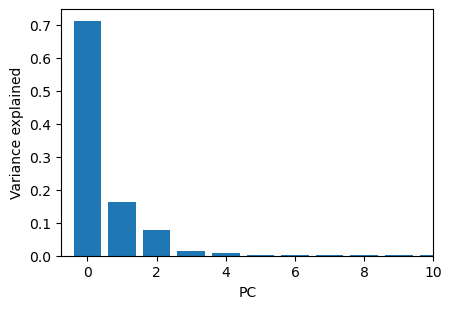

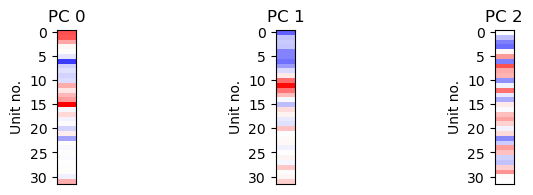

In [104]:
data_ = np.transpose(hidden_state_data, [1, 0, 2])
flattened_data = data_.reshape(data_.shape[0], data_.shape[1] * data_.shape[2])
print(data_.shape)
print(flattened_data.shape)
pca = PCA()
pc_activities = pca.fit_transform(flattened_data.T)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 2

print(pca.components_[:3, :])
fig, axs = plt.subplots(1, 3, figsize=(4 * scale, 1 * scale))
m = np.abs(pca.components_[:3, :]).max()
for i in range(3):
    axs[i].matshow(pca.components_[i, :].reshape(HIDDEN_SIZE, 1), vmin=-m, vmax=m, cmap='bwr', aspect=0.25)
    axs[i].set_xticks([])
    axs[i].set_ylabel('Unit no.')
    axs[i].set_title(f'PC {i}')

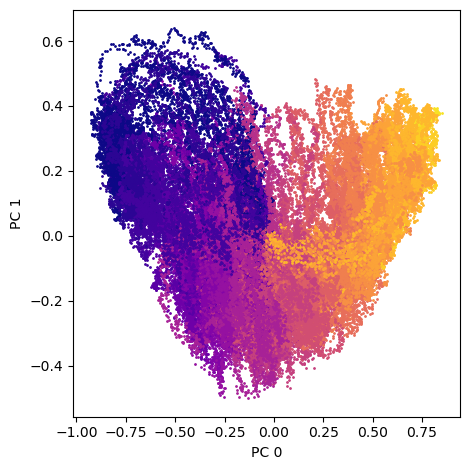

In [68]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 20))

for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[hidden_state_data.shape[2] * run_idx:hidden_state_data.shape[2] * (run_idx + 1), k],
            pc_activities[hidden_state_data.shape[2] * run_idx:hidden_state_data.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[int(output_data[0, run_idx] * 20 / 0.7)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

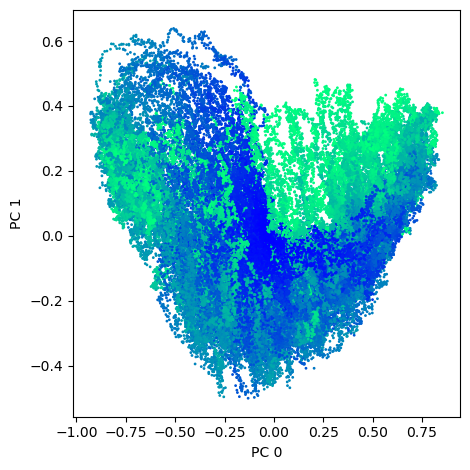

In [69]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['winter']
colors = cmap(np.linspace(0, 1, 500))

for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[hidden_state_data.shape[2] * run_idx:hidden_state_data.shape[2] * (run_idx + 1), k],
            pc_activities[hidden_state_data.shape[2] * run_idx:hidden_state_data.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[np.arange(500)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

(20, 2000, 500)
(20, 1000000)
[[ 0.39168614  0.37626046  0.20216635  0.02317801  0.00184805 -0.05749032
  -0.4294581  -0.10692772 -0.06855091 -0.09608934 -0.07728263  0.18671246
   0.0518176   0.1569546   0.22317863  0.5694077  -0.0183947   0.08555766
  -0.0237625  -0.009051  ]
 [-0.34152392 -0.12986147 -0.11560366 -0.12424541 -0.27082434 -0.27204415
  -0.30911997 -0.21699515 -0.07954109  0.04568023  0.32222566  0.5364803
   0.30334973  0.15051396 -0.01451706 -0.13639443  0.07536758  0.02951166
  -0.05268085 -0.06949971]
 [ 0.03125638 -0.13281158 -0.3050297  -0.35275003  0.01365316  0.2383958
  -0.34931222  0.41215244  0.20418395  0.1797077  -0.28085598 -0.02436208
   0.35565522 -0.047309   -0.19025208  0.09305538 -0.00536512  0.1640554
   0.220794    0.11074456]]


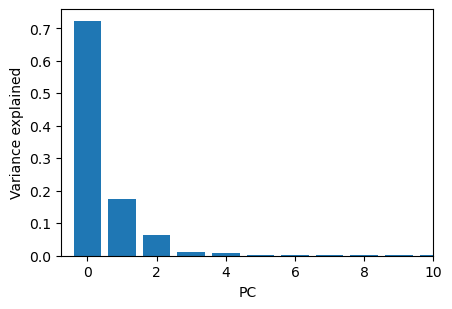

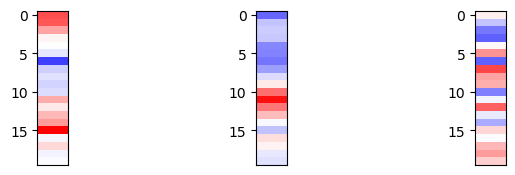

In [105]:
data_ = np.transpose(hidden_state_data, [1, 0, 2])
data_ = data_[:20, ...]
flattened_data = data_.reshape(data_.shape[0], data_.shape[1] * data_.shape[2])
print(data_.shape)
print(flattened_data.shape)
pca = PCA()
pc_activities = pca.fit_transform(flattened_data.T)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 2

print(pca.components_[:3, :])
fig, axs = plt.subplots(1, 3, figsize=(4 * scale, 1 * scale))
m = np.abs(pca.components_[:3, :]).max()
for i in range(3):
    axs[i].matshow(pca.components_[i, :].reshape(20, 1), vmin=-m, vmax=m, cmap='bwr', aspect=0.25)
    axs[i].set_xticks([])

C:\Users\david.bell\AppData\Local\Temp\ipykernel_20948\621727634.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs.scatter(


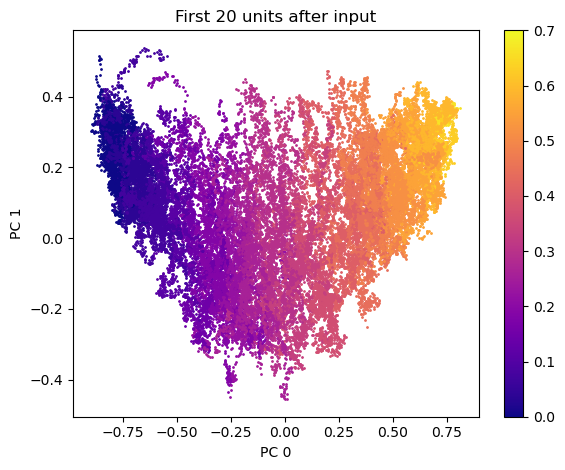

In [124]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(5 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 20))


for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        axs.scatter(
            pc_activities[data_.shape[2] * run_idx + 300:data_.shape[2] * (run_idx + 1), k],
            pc_activities[data_.shape[2] * run_idx + 300:data_.shape[2] * (run_idx + 1), k + 1],
            s=1,
            c=colors[int(output_data[0, run_idx] * 20 / 0.7)],
            # vmax=2,
        )
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(0, 0.7)
plt.colorbar(sm, ax=axs)
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
axs.set_title('First 20 units after input')
    # fig.colorbar(cbar)
fig.tight_layout()

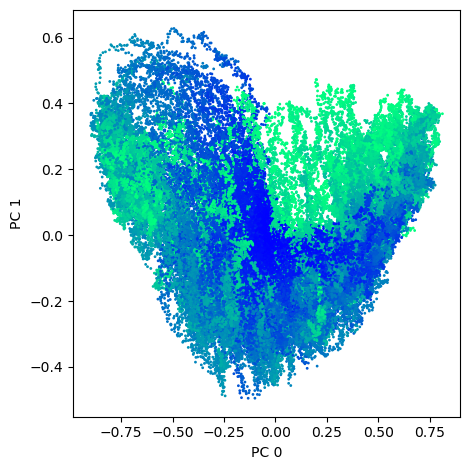

In [72]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
D
cmap = mpl.colormaps['winter']
colors = cmap(np.linspace(0, 1, 500))


for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[data_.shape[2] * run_idx:data_.shape[2] * (run_idx + 1), k],
            pc_activities[data_.shape[2] * run_idx:data_.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[np.arange(500)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

(12, 2000, 500)
(12, 1000000)


Text(0.5, 0, 'PC')

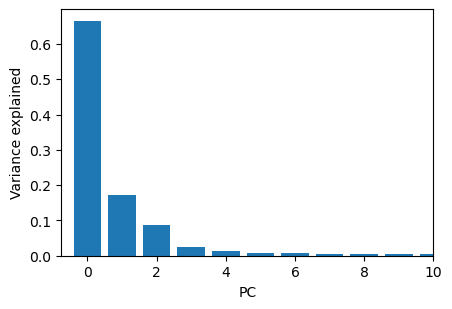

In [89]:
data_ = np.transpose(hidden_state_data, [1, 0, 2])
data_ = data_[20:, ...]
flattened_data = data_.reshape(data_.shape[0], data_.shape[1] * data_.shape[2])
print(data_.shape)
print(flattened_data.shape)
pca = PCA()
pc_activities = pca.fit_transform(flattened_data.T)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

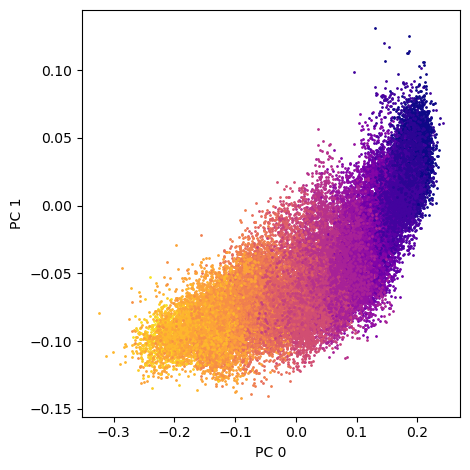

In [91]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 20))


for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[data_.shape[2] * run_idx + 300:data_.shape[2] * (run_idx + 1), k],
            pc_activities[data_.shape[2] * run_idx + 300:data_.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[int(output_data[0, run_idx] * 20 / 0.7)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

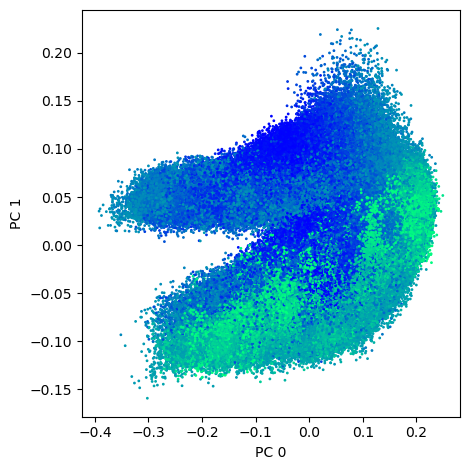

In [75]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['winter']
colors = cmap(np.linspace(0, 1, 500))


for run_idx in range(0, 1000, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[data_.shape[2] * run_idx:data_.shape[2] * (run_idx + 1), k],
            pc_activities[data_.shape[2] * run_idx:data_.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[np.arange(500)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

In [76]:
all_w_hh_trained = []
all_w_out = []
all_b_out = []

for i_d, d in enumerate(hypo_data):

    network_trained = GRU_RNN(
        input_size=INPUT_SIZE,
        hidden_size=HIDDEN_SIZE,
        device='cpu',
        var_noise=1e-7,
    )
    
    load_path = f'../../results/line_attr_supervised/{d}/rnn_weights/weights.h5'
    network_trained.load_state_dict(torch.load(load_path, weights_only=True))
    
    w_hh_trained = network_trained.rnn.weight_hh.detach().numpy()
    all_w_hh_trained.append(w_hh_trained)

    all_w_out.append(network_trained.output_arm.weight.detach().numpy())
    all_b_out.append(network_trained.output_arm.bias.detach().numpy())

(2000, 32, 500)
(2, 2000)


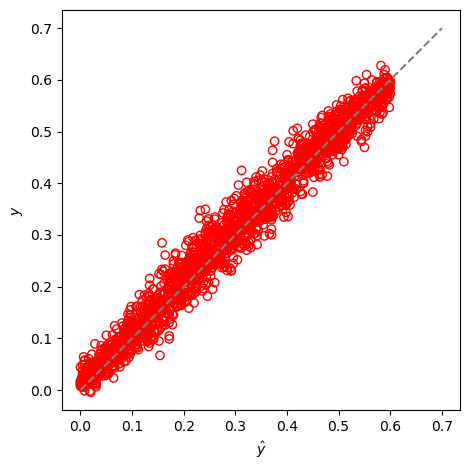

In [95]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 10))

print(hidden_state_data.shape)
print(output_data.shape)

cbar = axs.scatter(output_data[1, :], np.dot(all_w_out[0].flatten(), (hidden_state_data[..., 300:].mean(axis=2)).T) + all_b_out[0], edgecolor='red', facecolor='none')
axs.plot([0, 0.7], [0, 0.7], '--', c='gray')


axs.set_ylabel(r'$y$')
axs.set_xlabel(r'$\hat{y}$')
    # fig.colorbar(cbar)
fig.tight_layout()

(2000, 32, 500)
(2, 2000)


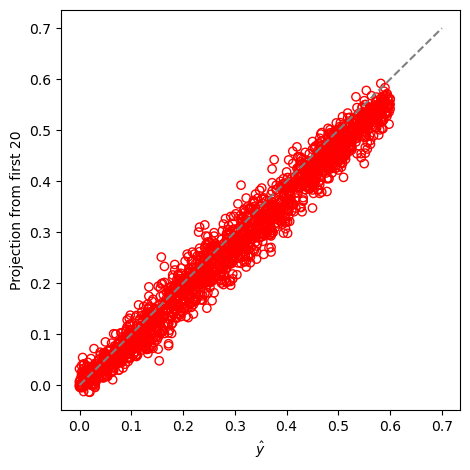

In [96]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 10))

print(hidden_state_data.shape)
print(output_data.shape)

cbar = axs.scatter(output_data[1, :], np.dot(all_w_out[0].flatten()[:20], (hidden_state_data[:, :20, 300:].mean(axis=2)).T) + all_b_out[0], edgecolor='red', facecolor='none')
axs.plot([0, 0.7], [0, 0.7], '--', c='gray')


axs.set_ylabel(r'Projection from first 20')
axs.set_xlabel(r'$\hat{y}$')
    # fig.colorbar(cbar)
fig.tight_layout()

(2000, 32, 500)
(2, 2000)


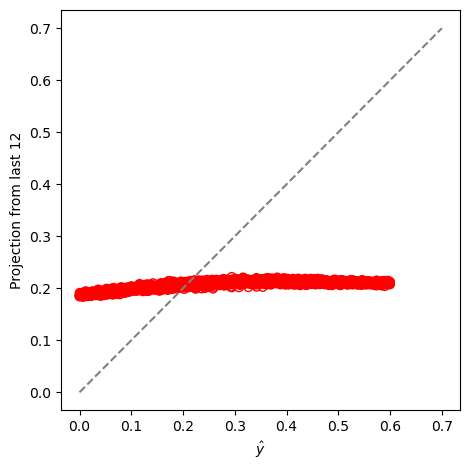

In [97]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 10))

print(hidden_state_data.shape)
print(output_data.shape)

cbar = axs.scatter(output_data[1, :], np.dot(all_w_out[0].flatten()[20:], (hidden_state_data[:, 20:, 300:].mean(axis=2)).T) + all_b_out[0], edgecolor='red', facecolor='none')
axs.plot([0, 0.7], [0, 0.7], '--', c='gray')


axs.set_ylabel(r'Projection from last 12')
axs.set_xlabel(r'$\hat{y}$')
    # fig.colorbar(cbar)
fig.tight_layout()